In [17]:
import torch
import numpy as np
from utils import prediction,normalization_2
import time
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Load the model and data. Then set the inference size, each dimension of the inference size must be divisible by 16, supporting up to 528x528x528 cuboid inference on a 16GB GPU.

In [18]:
model = torch.jit.load('network/FaultNet_Gamma07.pt').to(device)
data = np.load('data/kerry.npy').transpose((2, 0, 1))
infer_size = (272, 608, 256) # infer_size must be divisible by 16.

Inference

In [19]:
start = time.time()
result = prediction(model, data, device, infer_size)
end = time.time()
print('infer time:',end-start)

infer time: 8.82567834854126


Show result

In [20]:
def get_result_img (geo_slice, result_slice):
    hm = plt.get_cmap('bone')(geo_slice)[:, :, :-1]
    geo_slice = plt.get_cmap('seismic')(geo_slice)[:, :, :-1]
    logits = np.clip((result_slice[:, :, None]), a_min=0, a_max=1)
    colormap = plt.get_cmap('jet')(logits[:, :, 0])[:, :, :-1]
    hm = np.where(logits > 0.5, colormap, hm)
    return geo_slice, hm

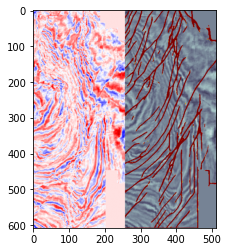

In [23]:
data = normalization_2(data)
tline_slice = data[150,:,:]
iline_slice = data[:,:,110]
xline_slice = data[:,280,:]
tline_result = result[150,:,:]
iline_result = result[:,:,110]
xline_result = result[:,280,:]
tline_slice,tline_result = get_result_img(tline_slice,tline_result)
iline_slice,iline_result = get_result_img(iline_slice,iline_result)
xline_slice,xline_result = get_result_img(xline_slice,xline_result)
tline = np.concatenate((tline_slice,tline_result),1)
iline = np.concatenate((iline_slice,iline_result),1)
xline = np.concatenate((xline_slice,xline_result),1)
plt.imshow(tline)


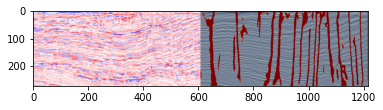

In [24]:
plt.imshow(iline)


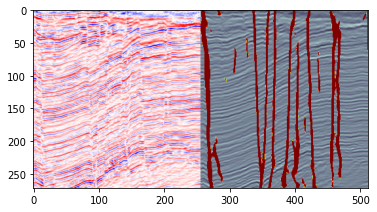

In [25]:
plt.imshow(xline)